# Unsupervised learning approach to refugee resettlement

In [45]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import HDBSCAN

import altair as alt
import umap.umap_ as umap

alt.data_transformers.disable_max_rows()  # Allows for plotting of larger datasets with Altair

DataTransformerRegistry.enable('default')

In [46]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.options.mode.chained_assignment = (
    None  # default='warn', this removes warning on dropping columns
)

warnings.filterwarnings(
    "ignore", category=DeprecationWarning
)  # Warning for future states of used libraries
warnings.simplefilter(
    action="ignore", category=FutureWarning
)  # Warning for future states of used libraries
warnings.simplefilter(
    action="ignore", category=UserWarning
)  # Warning for known bug with plotting the bar graphs

In [47]:
# Utility functions


def add_info_to_reduced(reduced, original, labels=None):
    """Transformed reduced data into a dataframe and adds target info"""
    reduced = pd.DataFrame(reduced)
    reduced.columns = reduced.columns.astype(str)
    reduced["Target"] = list(original["t_resettlement"])

    # Add clustering labels
    if labels is not None:
        reduced["Cluster"] = list(labels)

    return reduced


def viz_reduction(source, params, label="Target", c_scheme="reds"):
    """Produces 2D chart of reduced data"""

    # Produce chart
    chart = (
        alt.Chart(source)
        .mark_circle()
        .encode(
            x=alt.X("0", title="Component 1"),
            y=alt.Y("1", title="Component 2"),
            color=alt.Color(label, scale=alt.Scale(scheme=c_scheme)),
        )
        .configure_axis(grid=False)
        .properties(
            title="Visualization of ASR data using {}, {}".format(
                params["method"], params["year"]
            ),
            width=500,
            height=500,
        )
    )

    return chart

## Data Import and Prep

In [48]:
# Read in the dataset prepared in Create_Target notebook
rsp_df = pd.read_csv("../Data/processed/dataset_2016-19_target")

/tmp/ipykernel_201465/2996378173.py:2: DtypeWarning: Columns (53) have mixed types. Specify dtype option on import or set low_memory=False.
  rsp_df = pd.read_csv("../Data/processed/dataset_2016-19_target")


In [49]:
# Drop constructed variables
columns_to_drop = [col for col in rsp_df.columns if col.startswith("ui_")]
rsp_df.drop(columns_to_drop, axis=1, inplace=True)

# Drop answers that are binaries for sub-questions in the survey.
# These are asked post resettlement so wont be used in main work of this notebook.
ma = [
    "qn17_01",
    "qn17_02",
    "qn17_03",
    "qn17_04",
    "qn17_05",
    "qn17_06",
    "qn17_07",
    "qn17_08",
    "qn17_97",
    "qn31f",
    "qn33f",
    "qn34f",
    "qn26ha_01",
    "qn26ha_02",
    "qn26ha_03",
    "qn26ha_04",
    "qn26ha_05",
    "qn26ha_06",
    "qn26ha_07",
    "qn26ha_08",
    "qn29a_97",
    "qn29a_02",
    "qn29a_03",
    "qn29a_04",
    "qn29a_05",
    "qn29a_06",
    "qn29a_07",
    "qn29a_08",
    "qn29a_09",
    "qn29a_10",
    "qn29a_11",
    "qn29a_12",
    "qn29a_97",
    "qn29d_01",
    "qn29d_02",
    "qn29d_03",
    "qn29d_04",
    "qn29d_97",
]
rsp_df.drop(ma, axis=1, inplace=True)

In [50]:
# Features known before resettling
pre_feats = [
    "numppl",
    "qn1d",
    "qn1f",
    "qn1g",
    "qn1h",
    "qn1i",
    "qn2a",
    "qn2b",
    "qn3a",
    "qn4a",
    "qn4c",
    "qn1jyear",
    "t_resettlement",
]

# Features of current life
post_feats = [
    "qn1c",
    "qn4b",
    "qn4e",
    "qn4j",
    "qn5a",
    "qn5b",
    "qn6a",
    "qn6b",
    "qn7",
    "qn8a",
    "qn9",
    "qn10a",
    "qn11a",
    "qn11aa",
    "qn12",
    "qn13",
    "qn18b",
    "qn18dyear",
    "qn18e",
    "qn19b",
    "qn20",
    "qn24a",
    "qn24b",
    "qn25a",
    "qn25b",
    "qn25c",
    "qn25d",
    "qn26b",
    "qn26d",
    "qn26estate",
    "qn26f",
    "qn26h",
    "qn27a",
    "qn27bmnth",
    "qn30a",
    "qn30d",
    "qn31a",
    "qn31d",
    "qn31e",
    "qn32a",
    "qn32d",
    "qn32e",
    "qn33a",
    "qn33d",
    "qn33e",
    "qn34a",
    "qn34d",
    "qn34e",
    "qn35a",
    "qn38a",
    "qn38b",
    "qn38c",
]

### Pre-resettlement analysis

In [51]:
# Select only features identified as available at time of resettlement.
pre_df = rsp_df[pre_feats]

# Apply binary/ordinal encoding where needed, and convert relevant columns to numeric.
pre_df["qn1f"].replace(["male", "female"], [0, 1], inplace=True)
pre_df["qn4c"].replace(["no", "yes"], [0, 1], inplace=True)
pre_df["qn4a"].replace(
    [
        "not at all",
        "not well",
        "well",
        "very well",
    ],
    [0, 1, 2, 3],
    inplace=True,
)

pre_df["qn1f"] = pd.to_numeric(pre_df["qn1f"])
pre_df["qn4c"] = pd.to_numeric(pre_df["qn4c"])
pre_df["qn4a"] = pd.to_numeric(pre_df["qn4a"])

# To get our classifiers to work, we can't have NaNs. Since there are only 59 NaNs in the dataset, we drop them.
pre_df.dropna(inplace=True)

In [52]:
pre_df.head()

,numppl,qn1d,qn1f,qn1g,qn1h,qn1i,qn2a,qn2b,qn3a,qn4a,qn4c,qn1jyear,t_resettlement
0,4.0,70.0,0,bhutan,bhutan,other,0.0,none,not employed,0.0,0.0,2013.0,1
1,5.0,32.0,1,somalia,somalia,other,0.0,none,not employed,0.0,0.0,2015.0,0
2,1.0,38.0,0,somalia,somalia,other,5.0,none,not employed,1.0,0.0,2012.0,1
3,1.0,75.0,1,iraq,iraq,other,6.0,none,civil servant (civilian in local or national g...,0.0,0.0,2012.0,0
4,2.0,38.0,1,somalia,somalia,other,3.0,other,not employed,0.0,1.0,2015.0,0


In [53]:
pre_df.drop("qn1g", axis=1, inplace=True)

y = pre_df["t_resettlement"]
X = pre_df.drop("t_resettlement", axis=1)

In [54]:
# Given the high cardinality of our categorical features, we opt to use a target encoder.
# A good explanation of this technique can be found here: https://maxhalford.github.io/blog/target-encoding/
encoder = ce.TargetEncoder(return_df=True)
X = encoder.fit_transform(X, y)

In [55]:
# In order to for our classifiers to work as intended and be comparable to one another, we apply an sklearn.StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

## Dimensionality Reduction

#### PCA

In [56]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Print stats
print("Number of PCs: {}".format(len(pca.explained_variance_ratio_)))
print("Explained variation per PC: {}".format(pca.explained_variance_ratio_))
print("Sum of explained variation: {}".format(pca.explained_variance_ratio_.sum()))
print("\n")

Number of PCs: 2
Explained variation per PC: [0.20883406 0.16698216]
Sum of explained variation: 0.3758162150389237




In [57]:
# Set params for viz
params = {}
params["dataset"] = "Annual Survey of Refugees"
params["year"] = "2016-19"
params["indicator"] = "t_resettlement"

# PCA visualization with two components
params["method"] = "PCA"
viz_reduction(add_info_to_reduced(X_pca, pre_df), params)

alt.Chart(...)

From what we can see, PCA does not seem suitable for this dataset in terms of visualization and dimensionality reduction. Instead, we will attempt to use UMAP instead.

#### UMAP

In [58]:
# Visually tuning hyperparameters for UMAP


def draw_umap_grid(
    data,
    n_neighbors_options,
    min_dist_options,
    n_components=2,
    metric="euclidean",
):
    """Visually explores different hyperparameters for UMAP"""

    # Create figure
    nrows = len(n_neighbors_options)
    ncols = len(min_dist_options)

    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))

    # Handle special case
    if nrows == 1:
        axs = [axs]
    if ncols == 1:
        axs = [axs]

    # Iterate over all parameter combinations of n_neighbors and min_dist
    for i, n_neighbors in enumerate(n_neighbors_options):
        for j, min_dist in enumerate(min_dist_options):
            # Configure UMAP
            fit = umap.UMAP(
                n_neighbors=n_neighbors,
                min_dist=min_dist,
                n_components=n_components,
                random_state=42,
                metric=metric,
            )

            # Plot
            u = fit.fit_transform(data)
            ax = axs[i][j]
            ax.scatter(u[:, 0], u[:, 1])
            ax.set_title(
                f"Neighbors: {n_neighbors}, Min Dist: {min_dist}",
                fontsize=10,
            )
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

    # Adjust layout
    plt.tight_layout()
    plt.show()

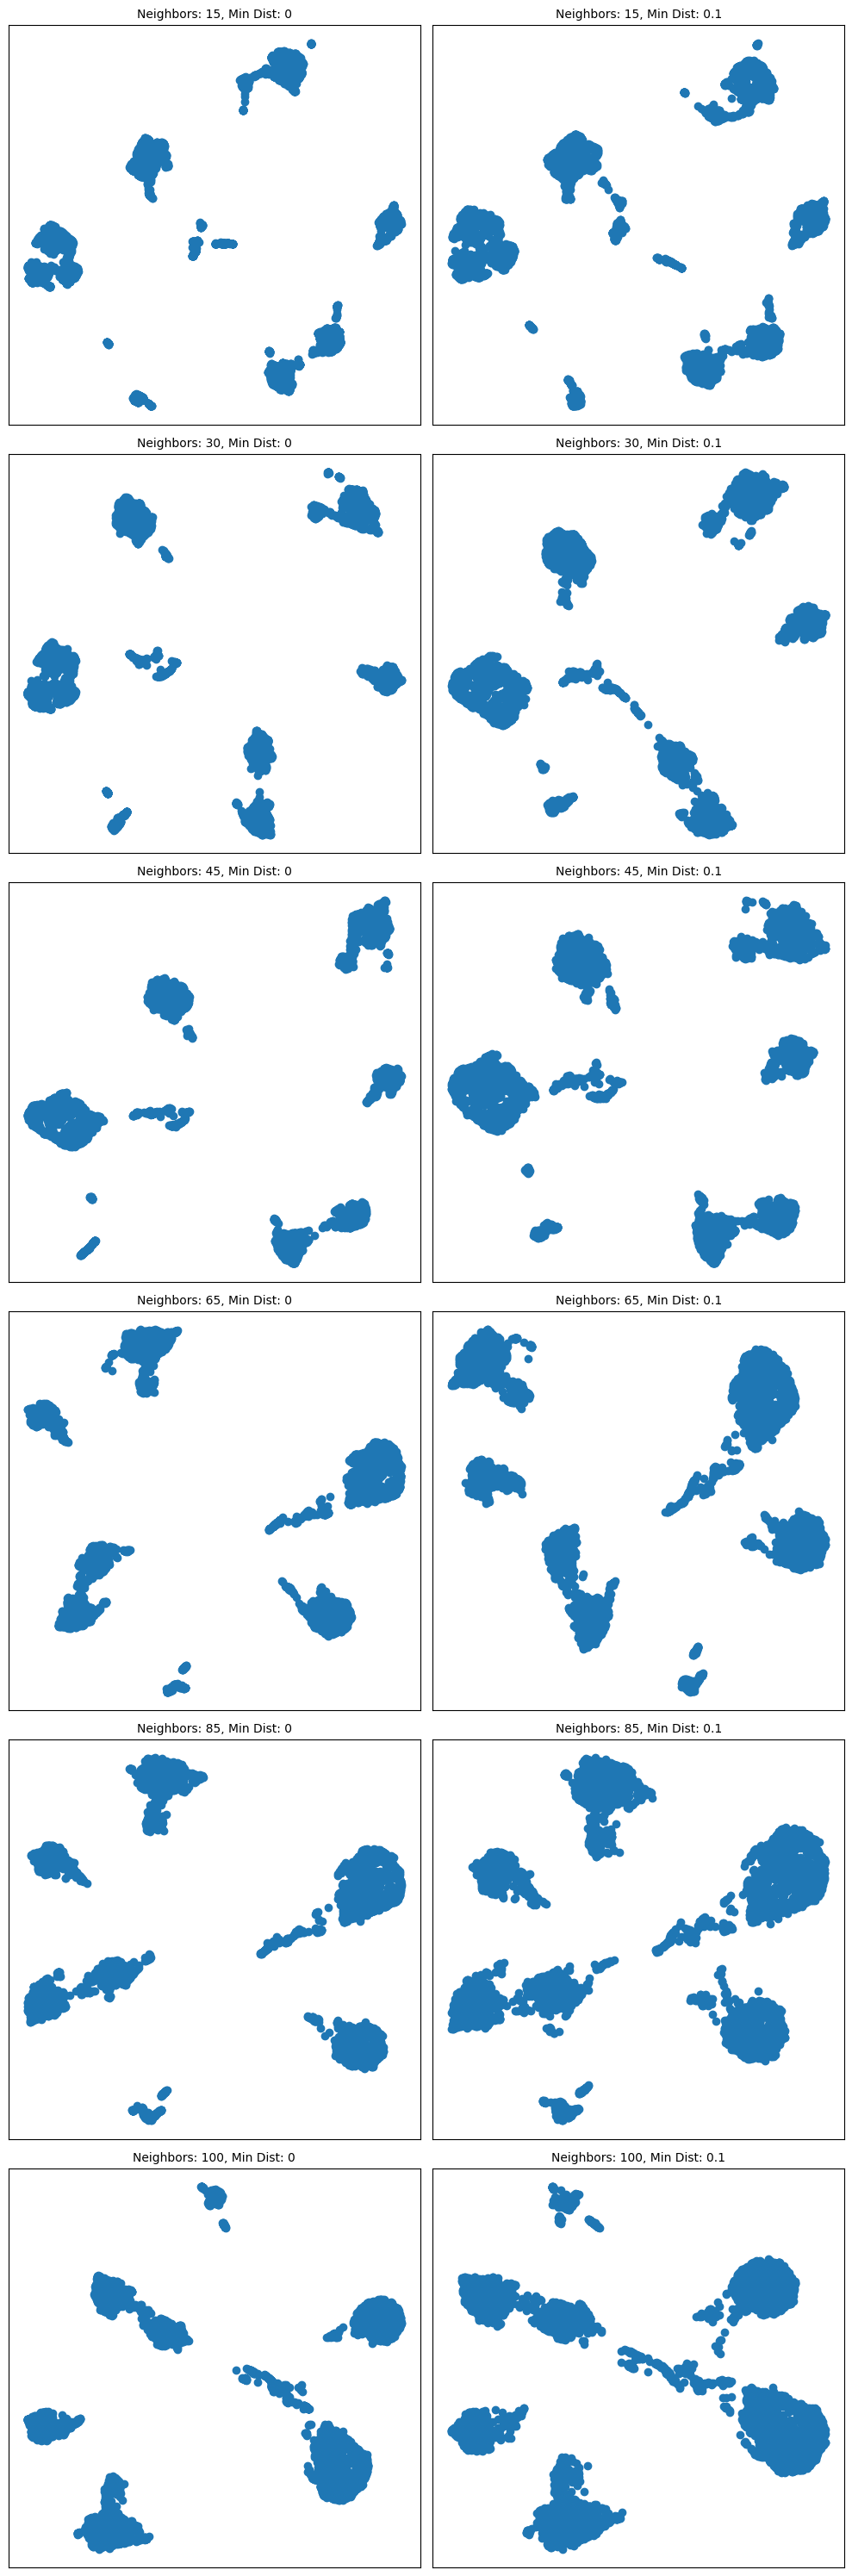

In [59]:
draw_umap_grid(X, (15, 30, 45, 65, 85, 100), (0, 0.1))

The hyper-parameters that we will use here are 100 for n_neighbors and 0 for min_dist, as these give us about 7-8 well-separated clusters.

In [94]:
# Final UMAP visualization
embeddings = umap.UMAP(
    n_components=2, n_neighbors=100, min_dist=0, random_state=42
).fit_transform(X)

params["method"] = "UMAP"
viz_reduction(add_info_to_reduced(embeddings, pre_df), params)

alt.Chart(...)

#### HDBSCAN Clustering

HDBSCAN is used here as it is not only well suited to complex cluster patterns, but it also has in-built outlier detection.

In [95]:
hdb = HDBSCAN(min_cluster_size=100)
hdb.fit(embeddings)

pre_df["cluster"] = hdb.labels_

In [102]:
# Visualize HDBSCAN Clustering results

params["method"] = "UMAP / HDBSCAN"
viz_reduction(
    add_info_to_reduced(embeddings, pre_df, hdb.labels_),
    params,
    label="Cluster:N",
    c_scheme="tableau10",
)

alt.Chart(...)

##### Cluster Investigation

In [103]:
# Size and average success rate of each cluster

df = pre_df[pre_df["cluster"] != -1] # Drop outliers found by HDBSCAN

cluster_stats = pd.concat(
    [
        df.groupby("cluster")["cluster"].count(),
        df.groupby("cluster")["t_resettlement"].mean(),
    ],
    axis=1,
).sort_values(by="t_resettlement")

cluster_stats.rename(columns={"cluster": "count"}, inplace=True)

cluster_stats

,count,t_resettlement
cluster,,
0,269,0.535316
4,464,0.605603
5,556,0.633094
3,850,0.668235
1,565,0.669027
7,1158,0.733161
2,972,0.758230
6,227,0.898678


In [104]:
# Mean values for all numeric qns in data
mean_numeric = (
    df.select_dtypes(include=[np.number])
    .groupby("cluster")
    .mean()
    .drop("t_resettlement", axis=1)
)

pd.concat([mean_numeric, cluster_stats], axis=1).sort_values(by="t_resettlement").round(
    2
)

,numppl,qn1d,qn1f,qn2a,qn4a,qn4c,qn1jyear,count,t_resettlement
cluster,,,,,,,,,
0,4.35,41.95,0.06,7.92,0.22,0.09,2016.05,269,0.54
4,3.44,43.21,1.00,4.21,0.28,0.00,2014.94,464,0.61
5,3.40,40.60,1.00,12.97,0.85,0.00,2015.06,556,0.63
3,3.57,42.40,0.01,5.90,0.42,0.00,2014.48,850,0.67
1,3.32,35.55,1.00,11.93,1.03,1.00,2015.05,565,0.67
7,3.36,40.28,0.00,13.42,1.20,0.00,2014.27,1158,0.73
2,2.97,37.33,0.00,11.87,1.20,1.00,2014.65,972,0.76
6,2.21,36.81,0.14,7.49,0.47,0.05,2013.74,227,0.90


In [105]:
# Most common value for each categorical qn in data


# Calculate mode and its percentage
def mode_with_percentage(group):
    mode_df = group.mode()
    for column in group:
        mode_count = group[column].eq(mode_df[column][0]).sum()
        percentage = (mode_count / len(group)) * 100
        mode_df[column] = f"{mode_df[column][0]} ({percentage:.2f}%)"
    return mode_df.iloc[[0]]


mode_cat = (
    pd.concat([df.select_dtypes(exclude=[np.number]), df["cluster"]], axis=1)
    .groupby("cluster")
    .apply(lambda x: mode_with_percentage(x))
    .reset_index(level=1, drop=True)
    .drop("cluster", axis=1)
)

pd.concat([mode_cat, cluster_stats], axis=1).sort_values(by="t_resettlement")

,qn1h,qn1i,qn2b,qn3a,count,t_resettlement
cluster,,,,,,
0,syria (98.88%),arab (87.73%),primary (71.38%),self-employed (62.08%),269,0.535316
4,somalia (20.04%),other (55.17%),none (64.01%),not employed (64.87%),464,0.605603
5,iraq (36.69%),other (37.77%),secondary (or high school diploma) (49.82%),not employed (35.97%),556,0.633094
3,iraq (36.82%),other (38.35%),primary (53.65%),self-employed (38.82%),850,0.668235
1,other (16.99%),other (54.34%),secondary (or high school diploma) (40.53%),not employed (27.79%),565,0.669027
7,iraq (58.64%),arab (45.68%),secondary (or high school diploma) (47.67%),self-employed (29.71%),1158,0.733161
2,iraq (23.56%),other (51.85%),secondary (or high school diploma) (40.84%),self-employed (34.98%),972,0.758230
6,burma (79.30%),chin (79.30%),none (35.24%),employed (unspecified if private or government...,227,0.898678


Mean resettlement success rate was found to be in a large range, from ~53% to ~90%. At a glance, there appears to be a strong correlation between education, English fluency (which goes from 0 - not at all to 3 - very well), and resettlement success. The most successful cluster appeared to be a small group from before the current wave of migration and consisted mostly of people from Burma. Barring that cluster, the most successful group on average were educated male refugees with fluency in English. The least successful clusters, in comparison, had the fewest years of education and the least proficiency in English. Prior English language training seemed to consistently boost average success by a few percentage points when comparing clusters.

### Post-Resettlement Analysis

In [106]:
merge = pd.merge(rsp_df, df, left_index=True, right_index=True, how="inner")

# Investigating post-resettlement English fluency
merge["qn4b"].replace(
    [
        "not at all",
        "not well",
        "well",
        "very well",
    ],
    [0, 1, 2, 3],
    inplace=True,
)
merge["qn4e"].replace(["no", "yes"], [0, 1], inplace=True)
merge["qn4j"].replace(["no", "yes"], [0, 1], inplace=True)

merge["qn4b"] = pd.to_numeric(merge["qn4b"])
merge["qn4e"] = pd.to_numeric(merge["qn4e"])
merge["qn4j"] = pd.to_numeric(merge["qn4j"])

In [107]:
# Comparing pre and post English fluency,
# along with whether respondent has enrolled in Eng. training in past 12 months and if they are currently enrolled in a program
Eng_flu = merge[["qn4a_y", "qn4b", "qn4e", "qn4j", "cluster"]].groupby("cluster").mean()

pd.concat([Eng_flu, cluster_stats], axis=1).sort_values(by="t_resettlement").round(2)

,qn4a_y,qn4b,qn4e,qn4j,count,t_resettlement
cluster,,,,,,
0,0.22,1.10,0.45,0.23,269,0.54
4,0.28,0.88,0.34,0.21,464,0.61
5,0.85,1.58,0.37,0.20,556,0.63
3,0.42,1.09,0.24,0.10,850,0.67
1,1.03,1.73,0.39,0.21,565,0.67
7,1.20,1.97,0.25,0.10,1158,0.73
2,1.20,1.91,0.33,0.15,972,0.76
6,0.47,1.15,0.14,0.07,227,0.90


Although we see a marked improvement in English in all groups post-resettlement when comparing 4a to 4b, a few still remain around a average level of 1 (not well). We also see that the majority of refugees post-resettlement have not attended an English training program either now or in the past 12 months, as shown by columns 4e and 4j, even for groups with lower English fluency such as 0, 4, and 3. It is possible that these programs may not be accessible to many refugees or that they may not have the time or availability to attend. Further investigation into the reasons behind why many refugees do not attend English training even when they could benefit is likely needed, and presents an avenue for future research. 